Figures related to the size of the HI-III-19 dataset. 

In [1]:
from collections import OrderedDict
from itertools import combinations, product

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.legend_handler import HandlerPatch
from matplotlib_venn import venn2, venn3

import ccsblib
from ccsblib import huri
from ccsblib import ccsbplotlib as cplt

from custom_settings import *
from utils import *


%matplotlib inline

In [2]:
comma_fmt = mpl.ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x)))
k_fmt = mpl.ticker.FuncFormatter(lambda x, p: '{:.0f}K'.format(float(x) / 1000) if float(x) > 0 else '0')

In [3]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7.0
mpl.rcParams['savefig.dpi'] = 500

In [4]:
hi = load_nw_hi_union()
hiIII = load_nw_hi_iii()   # this includes detailed screen information
lit = load_nw_lit_bm_17()
gsm = load_nw_gsm()

In [5]:
# Number of PPIs over time with literature also over time
qry = """SELECT *
           FROM lit17_v1.evidences_human;"""
lit_evid = pd.read_sql(qry, ccsblib.paros_connection())
pmid_date = pd.read_csv('../data/processed/pubmed_id_to_datetime.csv')
pmid_date = (pmid_date.drop_duplicates('pubmed_id')
                      .set_index('pubmed_id')
                      .datetime
                      .astype('datetime64'))
lit_evid['date'] = lit_evid['pubmed_id'].map(pmid_date)
lit_bm_evid = lit_evid.loc[lit_evid.groupby(['uniprot_id_a', 'uniprot_id_b']).date.transform('size') >= 2,
                           :]
date_2nd = (lit_bm_evid.sort_values('date')
                       .groupby(['uniprot_id_a', 'uniprot_id_b'])
                       .nth(1, dropna='any')
                       ['date'])
date_bin = (lit_bm_evid.loc[lit_bm_evid['binary'] == 1, :]
                       .sort_values('date')
                       .groupby(['uniprot_id_a', 'uniprot_id_b'])
                       .nth(0, dropna='any')
                       ['date'])
date_bm = (pd.merge(date_2nd.to_frame(),
                   date_bin.to_frame(),
                   how='inner',
                   on=['uniprot_id_a', 'uniprot_id_b']).max(axis=1))
date_bm.name = 'date'
litbm = huri.load_nw_lit_bm_17(id_type='uniprot_ac')
litbm = pd.merge(litbm,
                 date_bm.to_frame(),
                 how='left',
                 left_on=['uniprot_ac_a', 'uniprot_ac_b'],
                 right_on=['uniprot_id_a', 'uniprot_id_b'])
litbm = huri.map_nw_ids(litbm, 'uniprot_ac', 'ensembl_gene_id')
pcg = load_protein_coding_genome()
litbm = litbm.loc[litbm['ensembl_gene_id_a'].isin(pcg) &
                  litbm['ensembl_gene_id_b'].isin(pcg),
                  :]

/Users/lukelambourne/Work/ccsblib/ccsblib/huri/internal_data/ID_mapping.py:121: UserWarning: Warning: mapping between gene/protein identifiers has resulted in different pairs in the input ID being mapped to the same pair in the output ID.
You may wish to use the `agg` argument to customize the choice of which of the pair's infomation to keep or how to combine the information from multiple pairs.
  warnings.warn('Warning: mapping between gene/protein identifiers has '


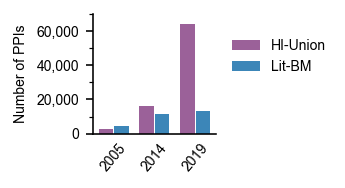

In [6]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(1.1, 1.1)
n_hi_2005 = hi['in_Rual'].sum()
n_hi_2014 = (hi['in_Rual'] | hi['in_Yu'] | hi['in_Venkatesan'] | hi['in_Rolland']).sum()
n_hi_2019 = hi.shape[0]
hi_x_pos = [0., 2.25, 4.5]
ax.bar(hi_x_pos,
       [n_hi_2005, n_hi_2014, n_hi_2019],
       color=HURI_COLOR,
       label='HI-Union')
offset = 0.85
ax.bar([x + offset for x in hi_x_pos],
       [(litbm['date'] <= '2005').sum(),
        (litbm['date'] <= '2014').sum(),
        litbm.shape[0]],
       color=LIT_COLOR,
       label='Lit-BM')
ax.set_xticks([x + offset / 2 for x in hi_x_pos])
ax.set_xticklabels(['2005', '2014', '2019'],
                   rotation=50)
ax.set_ylabel('Number of PPIs')
ax.xaxis.set_tick_params(length=0.)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 20000, 40000, 60000])
ax.set_yticks([10000, 30000, 50000, 70000], minor=True)
ax.yaxis.set_major_formatter(comma_fmt)
ax.legend(frameon=False,
          loc=1,
          bbox_to_anchor=[2., 0.9])
for fmt in FORMATS:
    plt.savefig('../figures/hi_union_and_lit_bm_over_time' + fmt,
                bbox_inches='tight')

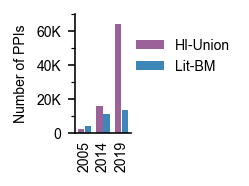

In [12]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(0.5, 1.1)
n_hi_2005 = hi['in_Rual'].sum()
n_hi_2014 = (hi['in_Rual'] | hi['in_Yu'] | hi['in_Venkatesan'] | hi['in_Rolland']).sum()
n_hi_2019 = hi.shape[0]
hi_x_pos = [0., 2.25, 4.5]
ax.bar(hi_x_pos,
       [n_hi_2005, n_hi_2014, n_hi_2019],
       color=HURI_COLOR,
       label='HI-Union')
offset = 0.85
ax.bar([x + offset for x in hi_x_pos],
       [(litbm['date'] <= '2005').sum(),
        (litbm['date'] <= '2014').sum(),
        litbm.shape[0]],
       color=LIT_COLOR,
       label='Lit-BM')
ax.set_xticks([x + offset / 2 for x in hi_x_pos])
ax.set_xticklabels(['2005', '2014', '2019'],
                   rotation=90)
ax.set_ylabel('Number of PPIs')
ax.xaxis.set_tick_params(length=0.)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 20000, 40000, 60000])
ax.set_yticks([10000, 30000, 50000, 70000], minor=True)
ax.yaxis.set_major_formatter(k_fmt)
ax.legend(frameon=False,
          loc=1,
          bbox_to_anchor=[3., 0.9])
for fmt in FORMATS:
    plt.savefig('../figures/hi_union_and_lit_bm_over_time_narrow' + fmt,
                bbox_inches='tight')

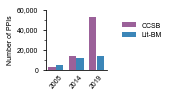

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(1.1, 1.1)
n_hi_2005 = hi['in_Rual'].sum()
n_hi_2014 = hi['in_Rolland'].sum()
n_hi_2019 = hi['in_HI_III'].sum()
hi_x_pos = [0., 2.25, 4.5]
ax.bar(hi_x_pos,
       [n_hi_2005, n_hi_2014, n_hi_2019],
       color=HURI_COLOR,
       label='CCSB')
offset = 0.85
ax.bar([x + offset for x in hi_x_pos],
       [(litbm['date'] <= '2005').sum(),
        (litbm['date'] <= '2014').sum(),
        litbm.shape[0]],
       color=LIT_COLOR,
       label='Lit-BM')
ax.set_xticks([x + offset / 2 for x in hi_x_pos])
ax.set_xticklabels(['2005', '2014', '2019'],
                   rotation=50)
ax.set_ylabel('Number of PPIs')
ax.xaxis.set_tick_params(length=0.)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 20000, 40000, 60000])
ax.set_yticks([10000, 30000, 50000], minor=True)
ax.yaxis.set_major_formatter(comma_fmt)
ax.legend(frameon=False,
          loc=1,
          bbox_to_anchor=[2., 0.9])
for fmt in FORMATS:
    plt.savefig('../figures/hi_and_lit_bm_over_time' + fmt,
                bbox_inches='tight')

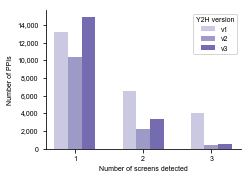

In [8]:
# n screens split by assay version;/l
# one with fraction, one with absoulute numbers
def n_screens_per_pair_by_assay_version(hiIII, norm=False, ax=None):
    n_screen_v1 = hiIII.loc[hiIII['in_assay_v1'],
                            ['in_screen_' + str(i) for i in range(1, 4)]].sum(axis=1).value_counts()
    n_screen_v2 = hiIII.loc[hiIII['in_assay_v2'],
                            ['in_screen_' + str(i) for i in range(4, 7)]].sum(axis=1).value_counts()
    n_screen_v3 = hiIII.loc[hiIII['in_assay_v6'],
                            ['in_screen_' + str(i) for i in range(7, 10)]].sum(axis=1).value_counts()
    width = 0.2
    if norm:
        n_screen_v1 = n_screen_v1 / n_screen_v1.sum()
        n_screen_v2 = n_screen_v2 / n_screen_v2.sum()
        n_screen_v3 = n_screen_v3 / n_screen_v3.sum()
    ax.bar(n_screen_v1.index - width,
           n_screen_v1.values,
           width=width,
           color=ASSAY_V1_COLOR,
           label='v1')
    ax.bar(n_screen_v2.index,
           n_screen_v2.values,
           width=width,
           color=ASSAY_V2_COLOR,
           label='v2')
    ax.bar(n_screen_v2.index + width,
           n_screen_v3.values, 
           width=width,
           color=ASSAY_V3_COLOR,
           label='v3')
    ax.set_xticks([1, 2, 3])
    ax.legend(title='Y2H version')
    ax.set_xlabel('Number of screens detected')
    if norm:
        ax.set_ylabel('Fraction of PPIs\nper Y2H version')
    else:
        ax.set_ylabel('Number of PPIs')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_major_formatter(comma_fmt)



fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3.5, 2.5)
n_screens_per_pair_by_assay_version(hiIII, ax=ax)
plt.tight_layout()
for fmt in FORMATS:
    plt.savefig('../figures/n_screens_per_pair_by_assay_version' + fmt)

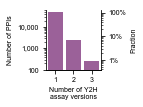

In [9]:
nassays = hiIII[['in_assay_v1', 'in_assay_v2', 'in_assay_v6']].sum(axis=1).value_counts()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2., 1.5)
ax.bar(nassays.index, nassays.values,
       color=HURI_COLOR)
ax.set_xticks([1, 2, 3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Number of Y2H\nassay versions')
ax.set_ylabel('Number of PPIs')


fassays = nassays / nassays.sum()
ax2 = ax.twinx()
ax2.bar(fassays.index, fassays.values,
        color=HURI_COLOR)

ax2.set_ylabel('Fraction')

ax.set_yscale('log')
ax2.set_yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_ylim(100, 60000)
ax.set_yticks([100, 1000, 10000])
ax.set_yticklabels(['100', '1,000', '10,000'])
ax2.set_yticks([0.01, 0.1, 1.])
ax2.set_yticklabels(['1%', '10%', '100%'])

plt.tight_layout()
for fmt in FORMATS:
    plt.savefig('../figures/num_PPIs_per_assay_version' + fmt)

In [10]:
def count_proteins(pairs, idType='ensembl_gene_id'):
    """Number of unique proteins in PPI dataset"""
    return len(set(pairs[idType + '_a'].unique()).union(set(pairs[idType + '_b'].unique())))

In [11]:
# Getting the average of all combinations of three screens of v1
# followed by 1, 2, 3 screens of v2
n_ppi_v2_screens456 = []
n_proteins_v2_screens456 = []
n_screens_v1 = 3
n_screens_v2 = 3
n_screens_total_v1 = 12
n_screens_total_v2 = 3
n_screens_total_v6 = 6
for n_v2 in [1, 2, 3]:
    each_combo = []
    each_combo_proteins = []
    for cc_i, hy_i in product(combinations(range(n_screens_total_v1), n_screens_v1),
                              combinations(range(n_screens_total_v2), n_v2)):
        n_ppi = (gsm.loc[:, ['in_screen_v1_' + str(j + 1) for j in cc_i] + 
                            ['in_screen_v2_' + str(k + 1) for k in hy_i]]
                    .any(axis=1)
                    .sum())
        n_proteins = count_proteins(gsm.loc[gsm[['in_screen_v1_' + str(j + 1) for j in cc_i] + 
                                                ['in_screen_v2_' + str(k + 1) for k in hy_i]]
                                               .any(axis=1),
                                            :],
                                    idType='orf_id')
        each_combo.append(n_ppi)
        each_combo_proteins.append(n_proteins)
    n_ppi_v2_screens456.append(np.mean(each_combo))
    n_proteins_v2_screens456.append(np.mean(each_combo_proteins))
    
n_ppi_v3_screens789 = []
n_proteins_v3_screens789 = []
for n_v6 in [1, 2, 3]:
    each_combo = []
    each_combo_proteins = []
    for cc_i, hy_i, v6_i in product(combinations(range(n_screens_total_v1), n_screens_v1), 
                                    combinations(range(n_screens_total_v2), n_screens_v2),
                                    combinations(range(n_screens_total_v6), n_v6)):
        n_ppis = (gsm.loc[:, ['in_screen_v1_' + str(j + 1) for j in cc_i] +
                             ['in_screen_v2_' + str(k + 1) for k in hy_i] +
                             ['in_screen_v6_' + str(m + 1) for m in v6_i]]
                     .any(axis=1)
                     .sum())
        n_proteins = count_proteins(gsm.loc[gsm[['in_screen_v1_' + str(j + 1) for j in cc_i] + 
                                                ['in_screen_v2_' + str(k + 1) for k in hy_i] +
                                                ['in_screen_v6_' + str(m + 1) for m in v6_i]]
                                       .any(axis=1),
                                    :],
                                   idType='orf_id')
        each_combo.append(n_ppis)
        each_combo_proteins.append(n_proteins)
    n_ppi_v3_screens789.append(np.mean(each_combo))
    n_proteins_v3_screens789.append(np.mean(each_combo_proteins))

In [12]:
def n_screens_plot(hi, screen_columns, ax=None):
    n_screens = len(screen_columns)
    screen_numbers = list(range(1, n_screens + 1))
    ppis_count = []
    for screen_i in screen_numbers:
        ppis_count.append(hi.loc[:, screen_columns[:screen_i]]
                            .any(axis=1)
                            .sum())
    ax.plot(screen_numbers,
            ppis_count,
            '-',
            color=HURI_COLOR)
    ax.plot(screen_numbers[:3],
            ppis_count[:3],
            '^',
            color=ASSAY_V1_COLOR)
    ax.plot(screen_numbers[3:6],
            ppis_count[3:6],
            'o',
            color=ASSAY_V2_COLOR)
    ax.plot(screen_numbers[6:],
            ppis_count[6:],
            's',
            color=ASSAY_V3_COLOR)
    ax.set_xticks(list(range(1, n_screens + 1)))
    #ax.set_ylabel('Number of PPIs')
    ax.set_xlabel('Number of screens')
    ax.set_ylim((0., max(ppis_count) * 1.05))
    ax.set_yticks([0, 20000, 40000, 60000])
    ax.yaxis.set_major_formatter(k_fmt)
    

def n_proteins_plot(hi, screen_columns, ax=None):
    n_screens = len(screen_columns)
    screen_numbers = list(range(1, n_screens + 1))
    proteins_count = []
    for screen_i in screen_numbers:
        proteins_count.append(count_proteins(hi.loc[hi[screen_columns[:screen_i]].any(axis=1), :]))
    ax.plot(screen_numbers,
            proteins_count,
            '-',
            color=HURI_COLOR)
    ax.plot(screen_numbers[:3],
            proteins_count[:3],
            '^',
            color=ASSAY_V1_COLOR,
            label='v1')
    ax.plot(screen_numbers[3:6],
            proteins_count[3:6],
            'o',
            color=ASSAY_V2_COLOR,
            label='v2')
    ax.plot(screen_numbers[6:],
            proteins_count[6:],
            's',
            color=ASSAY_V3_COLOR,
            label='v3')
    ax.set_xticks(list(range(1, n_screens + 1)))
    #ax.set_ylabel('Number of proteins')
    ax.set_xlabel('Number of screens')
    ax.set_ylim((0., max(proteins_count) * 1.05))
    ax.yaxis.set_major_formatter(k_fmt)
    ax.set_yticks([0, 2000, 4000, 6000, 8000])



def averaged_cumulative_screens_plot(hi, screen_columns, ax=None, **kwargs):
    """Shuffle the order of the screens taking the average.
    In the case where the order of the screens is unimportant
    this will smooth out some of the per-screen variability
    to better see what the satuaration behavior looks like.
    """
    n_screens = len(screen_columns)
    screen_numbers = list(range(1, n_screens + 1))
    ppis_count = []
    for n in range(n_screens):
        ppis_count.append(np.mean(
            [hi.loc[:, [screen_columns[j] for j in i]]
                            .any(axis=1)
                            .sum() for i in combinations(range(n_screens), n+1)]))
    ax.plot(screen_numbers, ppis_count, '^-', **kwargs)
    ax.set_xlabel('Number of screens')
    return ppis_count


def averaged_proteins_cumulative_screens_plot(hi, screen_columns, ax=None, **kwargs):
    """Shuffle the order of the screens taking the average.
    In the case where the order of the screens is unimportant
    this will smooth out some of the per-screen variability
    to better see what the satuaration behavior looks like.
    """
    n_screens = len(screen_columns)
    screen_numbers = list(range(1, n_screens + 1))
    proteins_count = []
    for n in range(n_screens):
        proteins_count.append(np.mean(
            [count_proteins(hi.loc[hi[[screen_columns[j] for j in i]].any(axis=1),
                                  :], idType='orf_id') for i in combinations(range(n_screens), n+1)]))
    ax.plot(screen_numbers, proteins_count, '^-', **kwargs)
    ax.set_xlabel('Number of screens')
    return proteins_count

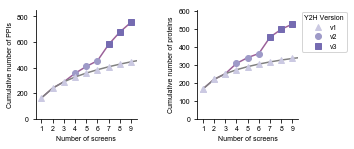

In [13]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(4.7, 2.0)
 
v1 = averaged_cumulative_screens_plot(gsm,
                                      ['in_screen_v1_' + str(i) for i in range(1, 13)],
                                      ax=axes[0],
                                      label='',
                                      color='grey',
                                      markerfacecolor=ASSAY_V1_COLOR,
                                      markeredgecolor=ASSAY_V1_COLOR)

axes[0].plot([1, 2, 3, 4, 5, 6, 7, 8, 9],
                v1[:3] + n_ppi_v2_screens456 + n_ppi_v3_screens789,
                '-',
                color=HURI_COLOR,
                label='',
                zorder=0)
axes[0].plot([4, 5, 6],
                n_ppi_v2_screens456,
                'o',
                color=ASSAY_V2_COLOR,
                label='',
                zorder=0)
axes[0].plot([7, 8, 9],
                n_ppi_v3_screens789,
                's',
                color=ASSAY_V3_COLOR,
                label='',
                zorder=0)
v1 = averaged_proteins_cumulative_screens_plot(gsm,
                                               ['in_screen_v1_' + str(i) for i in range(1, 13)],
                                               label='',
                                               ax=axes[1],
                                               color='grey',
                                               markerfacecolor=ASSAY_V1_COLOR,
                                               markeredgecolor=ASSAY_V1_COLOR)

# number of proteins in test space
axes[1].plot([1, 2, 3, 4, 5, 6, 7, 8, 9],
                v1[:3] + n_proteins_v2_screens456 + n_proteins_v3_screens789,
                '-',
                color=HURI_COLOR,
                zorder=0)
axes[1].plot([1, 2, 3],
                v1[:3],
                '^',
                color=ASSAY_V1_COLOR,
                label='v1',
                zorder=0)
axes[1].plot([4, 5, 6],
                n_proteins_v2_screens456,
                'o',
                color=ASSAY_V2_COLOR,
                label='v2',
                zorder=0)
axes[1].plot([7, 8, 9],
                n_proteins_v3_screens789,
                's',
                color=ASSAY_V3_COLOR,
                label='v3',
                zorder=0)

axes[0].set_ylabel('Cumulative number of PPIs')
axes[1].set_ylabel('Cumulative number of proteins')

for ax in axes.flatten():
    ax.set_xticks(list(range(1, 10)))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim((0.5, 9.5))
axes[0].set_ylim(0, 850)
axes[0].set_yticks(range(0, 820, 200))
axes[1].set_ylim(0, 605)
box = axes[1].get_position()
axes[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
axes[1].legend(title='Y2H Version',
           loc='center left',
           bbox_to_anchor=(1., 0.8))
plt.subplots_adjust(wspace=0.6)
for fmt in FORMATS:
    plt.savefig('../figures/proteins_vs_interactions_test' + fmt,
                bbox_inches='tight')

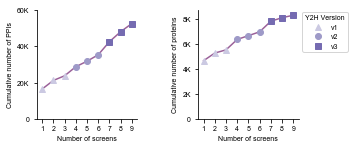

In [14]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(4.7, 2.0)
n_screens_plot(hiIII,
               ['in_screen_' + str(i) for i in range(1, 10)],
               ax=axes[0])
n_proteins_plot(hiIII,
                ['in_screen_' + str(i) for i in range(1, 10)],
                ax=axes[1])
    
axes[0].set_ylabel('Cumulative number of PPIs')
axes[1].set_ylabel('Cumulative number of proteins')
    
for ax in axes.flatten():
    ax.set_xticks(list(range(1, 10)))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim((0.5, 9.5))
axes[1].legend(title='Y2H Version',
           loc='center left',
           bbox_to_anchor=(1., 0.8))
           #labelspacing=1.2)

plt.subplots_adjust(wspace=0.6)


for fmt in FORMATS:
    plt.savefig('../figures/proteins_vs_interactions_full' + fmt,
                bbox_inches='tight')

In [15]:
spaceIII = load_space_iii(id_type='ensembl_gene_id')

In [8]:
n_pub = load_number_publications_per_gene()
n_pub = n_pub[n_pub.index.isin(pcg)]

In [17]:
litbm = load_nw_lit_bm_17()

In [18]:
from matplotlib.colors import LinearSegmentedColormap
hi_cmap = LinearSegmentedColormap.from_list('HI-III-19', ['white', HURI_COLOR, 'black'], 1000)
lit_cmap = LinearSegmentedColormap.from_list('Lit-BM', ['white', LIT_COLOR, 'black'], 1000)
plt.register_cmap(name=hi_cmap.name, cmap=hi_cmap)
plt.register_cmap(name=lit_cmap.name, cmap=lit_cmap)

In [19]:
hiU = load_nw_hi_union()
hi_I_05 = hiU.loc[hiU['in_Rual'], :].copy()
hi_II_14 = hiU.loc[hiU['in_Rolland'], :].copy()

In [4]:
qry = """SELECT *
          FROM lit17_v1.evidences_human;"""
lit_evid = pd.read_sql(qry, ccsblib.paros_connection())
pmid_date = pd.read_csv('../data/processed/pubmed_id_to_datetime.csv')
pmid_date = (pmid_date.drop_duplicates('pubmed_id')
                     .set_index('pubmed_id')
                     .datetime
                     .astype('datetime64'))
lit_evid['date'] = lit_evid['pubmed_id'].map(pmid_date)
lit_bm_evid = lit_evid.loc[lit_evid.groupby(['uniprot_id_a', 'uniprot_id_b']).date.transform('size') >= 2,
                          :]
date_2nd = (lit_bm_evid.sort_values('date')
                      .groupby(['uniprot_id_a', 'uniprot_id_b'])
                      .nth(1, dropna='any')
                      ['date'])
date_bin = (lit_bm_evid.loc[lit_bm_evid['binary'] == 1, :]
                      .sort_values('date')
                      .groupby(['uniprot_id_a', 'uniprot_id_b'])
                      .nth(0, dropna='any')
                      ['date'])
date_bm = (pd.merge(date_2nd.to_frame(),
                  date_bin.to_frame(),
                  how='inner',
                  on=['uniprot_id_a', 'uniprot_id_b']).max(axis=1))
date_bm.name = 'date'
litbm = huri.load_nw_lit_bm_17(id_type='uniprot_ac')
litbm = pd.merge(litbm,
                date_bm.to_frame(),
                how='left',
                left_on=['uniprot_ac_a', 'uniprot_ac_b'],
                right_on=['uniprot_id_a', 'uniprot_id_b'])
litbm = huri.map_nw_ids(litbm, 'uniprot_ac', 'ensembl_gene_id')

You may wish to use the `agg` argument to customize the choice of which of the pair's infomation to keep or how to combine the information from multiple pairs.


In [21]:
litbm_2014 = litbm.loc[litbm['date'] <= '2014', :]
litbm_2005 = litbm.loc[litbm['date'] <= '2005', :]

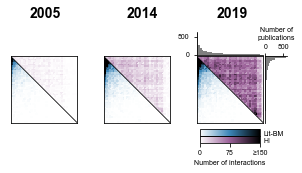

In [22]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(5, 5/3)
plt.subplots_adjust(wspace=0.)
for ax, ds, name in zip(axes, 
                        [(hi_I_05, litbm_2005), (hi_II_14, litbm_2014), (hiIII, litbm)],
                        ['HI-I-05', 'HI-II-14', 'HI-III-19']):
    new_axes = cplt.samogram_double(ds,
                                     n_pub,
                                     n_bins=40,
                                     color='grey',
                                     draw_right=(name == 'HI-III-19'),
                                     draw_up=(name == 'HI-III-19'),
                                     draw_scale=(name == 'HI-III-19'),
                                     cmaps=('HI-III-19', 'Lit-BM'),
                                     zticks=[0, 75, 150],
                                     vmax=150,
                                     ylabel='Number of\npublications',
                                     ax=ax,
                                     size_ratio=0.25,
                                     colorbar_width=0.9,
                              labels=('HI', 'Lit-BM'))
    if name == 'HI-III-19':
        new_axes[1].set_ylabel('')
fig.text(0.18, 1., '2005', fontsize=14, weight='bold')
fig.text(0.45, 1., '2014', fontsize=14, weight='bold')
fig.text(0.7, 1., '2019', fontsize=14, weight='bold')
for fmt in FORMATS:
    plt.savefig('../figures/samograms_timeline' + fmt,
                bbox_inches='tight')